In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.metrics import cohen_kappa_score

# The PCR for alpha1&2 (balanced)

In [2]:
# EC50 data balanced
descriptorsSet=pd.read_csv('balanced.csv')

In [3]:
descriptorsSet.columns

Index(['cid', 'acvalue', 'smiles', 'Activity', 'nAcid', 'ALogP', 'ALogp2',
       'AMR', 'apol', 'naAromAtom',
       ...
       'P1s', 'P2s', 'E1s', 'E2s', 'E3s', 'Ts', 'As', 'Vs', 'Ks', 'Ds'],
      dtype='object', length=1879)

In [4]:
#performing PCA (with unormalized data, scale them during the PCA)
X = descriptorsSet.drop([ "acvalue",'smiles','Activity'], axis = 1)
y = descriptorsSet['acvalue']

# Split data into training and test sets
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=1)
#Replace with name of the standardised table

In [5]:
#scale predictor variables
pca1 = PCA()

X_reduced_train = pca1.fit_transform(scale(X_train))
n = len(X_reduced_train)
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

#define cross validation method

cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 11):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced_train[:,:i], y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

mse

[19.896874278818593,
 19.771704165463298,
 19.67790763746186,
 19.661773586192513,
 19.640797142790742,
 19.526984336073433,
 19.690536954182342,
 19.83335789649843,
 20.40410932385843,
 19.993769854468237,
 20.08384438967735]

Text(0.5, 1.0, 'Principle Component Analysis')

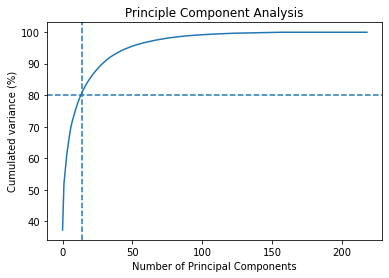

In [6]:
# Plot cross-validation results    
cum_explained_var = np.cumsum(np.round(pca1.explained_variance_ratio_, decimals=4)*100)

plt.plot(cum_explained_var)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulated variance (%)')
plt.axhline(y=80, linestyle='--')
plt.axvline(x = 14, linestyle='--')
plt.title('Principle Component Analysis')

In [7]:
np.cumsum(np.round(pca1.explained_variance_ratio_, decimals=4)*100)

array([37.29, 51.89, 56.63, 61.04, 64.31, 67.35, 69.97, 71.77, 73.41,
       74.93, 76.35, 77.69, 78.86, 79.94, 80.92, 81.87, 82.69, 83.46,
       84.2 , 84.88, 85.54, 86.15, 86.73, 87.29, 87.83, 88.35, 88.84,
       89.3 , 89.74, 90.16, 90.56, 90.94, 91.31, 91.66, 91.98, 92.29,
       92.57, 92.84, 93.1 , 93.35, 93.6 , 93.84, 94.07, 94.28, 94.48,
       94.67, 94.85, 95.02, 95.19, 95.36, 95.52, 95.67, 95.82, 95.96,
       96.09, 96.22, 96.34, 96.46, 96.57, 96.68, 96.78, 96.88, 96.98,
       97.08, 97.18, 97.27, 97.36, 97.45, 97.53, 97.61, 97.69, 97.77,
       97.84, 97.91, 97.98, 98.05, 98.12, 98.18, 98.24, 98.3 , 98.36,
       98.41, 98.46, 98.51, 98.56, 98.61, 98.66, 98.7 , 98.74, 98.78,
       98.82, 98.86, 98.9 , 98.94, 98.97, 99.  , 99.03, 99.06, 99.09,
       99.12, 99.15, 99.18, 99.21, 99.24, 99.27, 99.29, 99.31, 99.33,
       99.35, 99.37, 99.39, 99.41, 99.43, 99.45, 99.47, 99.49, 99.51,
       99.53, 99.55, 99.57, 99.59, 99.6 , 99.61, 99.62, 99.63, 99.64,
       99.65, 99.66,

M = 14, 80%

In [8]:
X_reduced_test = pca1.transform(scale(X_test))[:,:15]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:15], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

3.10390319488288

In [10]:
print(regr.coef_) # regression coefficient
print(regr.intercept_)  # error W0 ?

[ 0.01591001 -0.02455154  0.06729357 -0.03000589  0.09861157  0.00471207
  0.01383662 -0.03674347  0.16949713  0.00819094 -0.09596095  0.13702796
 -0.02657516 -0.05640026 -0.05224305]
1.166646119583586


In [11]:
# R squared, coefficient of determination
# the percentatge of the dependent variable variation that a linear model explains

print(regr.score(X_reduced_test,y_test)) 

-1.7397306803570576


A negative R-squared indicates that PCR performs worse than a regressor that would simply predict the mean of the target.

coefficient of determination
the percentage of the dependent variable variation that a linear model explains.

# pcr for alpha 1 & 2 (unbalanced)

In [12]:
#unbalanced
descriptorsSet=pd.read_csv('unbalancedFinal.csv')

In [13]:
#performing PCA (with unormalized data, scale them during the PCA)
X = descriptorsSet.drop(["id", "standard_value",'canonical_smiles','Activity'], axis = 1)
y = descriptorsSet['standard_value']

# Split data into training and test sets
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=1)
#Replace with name of the standardised table

In [14]:
#scale predictor variables
pca2 = PCA()

X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

#define cross validation method
cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 11):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced_train[:,:i], y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

mse

[158476352.1176521,
 158591145.31875813,
 157512781.41828287,
 158874247.27797756,
 158666929.29492572,
 159545966.54332945,
 160696465.67637032,
 160907342.2376982,
 162610985.77789447,
 163989516.7108356,
 165502905.6281882]

Text(0.5, 1.0, 'Principle Component Analysis')

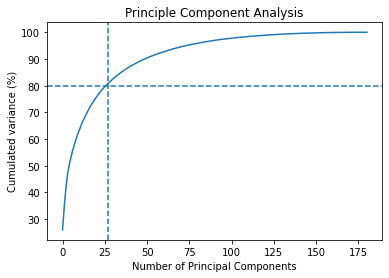

In [21]:
# Plot cross-validation results    
cum_explained_var = np.cumsum(np.round(pca2.explained_variance_ratio_, decimals=4)*100)

plt.plot(cum_explained_var)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulated variance (%)')
plt.axhline(y=80, linestyle='--')
plt.axvline(x = 27, linestyle='--')
plt.title('Principle Component Analysis')

In [22]:
X_reduced_test = pca2.transform(scale(X_test))[:,:28]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:28], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

168850783.16378593

In [23]:
np.cumsum(np.round(pca2.explained_variance_ratio_, decimals=4)*100)

array([ 25.96,  34.57,  41.7 ,  47.14,  50.42,  53.29,  55.77,  58.  ,
        59.97,  61.89,  63.53,  65.15,  66.66,  68.06,  69.38,  70.6 ,
        71.76,  72.87,  73.86,  74.83,  75.74,  76.62,  77.46,  78.25,
        78.99,  79.67,  80.31,  80.92,  81.52,  82.1 ,  82.68,  83.22,
        83.74,  84.23,  84.71,  85.17,  85.62,  86.05,  86.46,  86.85,
        87.24,  87.61,  87.96,  88.31,  88.64,  88.96,  89.27,  89.56,
        89.85,  90.14,  90.42,  90.69,  90.95,  91.2 ,  91.44,  91.67,
        91.9 ,  92.12,  92.33,  92.54,  92.75,  92.96,  93.16,  93.35,
        93.54,  93.73,  93.91,  94.08,  94.25,  94.41,  94.57,  94.72,
        94.87,  95.02,  95.16,  95.3 ,  95.44,  95.57,  95.7 ,  95.82,
        95.94,  96.06,  96.18,  96.29,  96.4 ,  96.51,  96.61,  96.71,
        96.81,  96.91,  97.01,  97.1 ,  97.19,  97.28,  97.36,  97.44,
        97.52,  97.6 ,  97.68,  97.75,  97.82,  97.89,  97.96,  98.03,
        98.09,  98.15,  98.21,  98.27,  98.33,  98.39,  98.45,  98.5 ,
      

M=27, >80%

In [24]:
# R squared, coefficient of determination
# the percentatge of the dependent variable variation that a linear model explains

print(regr.score(X_reduced_test,y_test)) # acc

-0.024879816106848862


In [184]:
#kappa - range:[-1,1], the larger, the better - when the dataset is unbalanced
# kappa_value = cohen_kappa_score(y_true, y_pred)
# print("kappa value is %f" % kappa_value)

# pcr for only alpha1

(tired with old )

In [15]:
descriptorsSet=pd.read_csv('alpha1.csv')

In [16]:
#performing PCA (with unormalized data, scale them during the PCA)
X = descriptorsSet.drop(["id", "standard_value",'canonical_smiles','bioactivity_class'], axis = 1)
y = descriptorsSet['standard_value']

# Split data into training and test sets
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=1)
#Replace with name of the standardised table

In [17]:
#scale predictor variables
pca4 = PCA()

X_reduced_train = pca4.fit_transform(scale(X_train))
n = len(X_reduced_train)
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

#define cross validation method
cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 11):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced_train[:,:i], y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

mse

[149445570.93025467,
 149052173.26156074,
 149378737.5069442,
 148718420.95886895,
 151119681.24152473,
 147488872.26527134,
 134224132.70180798,
 127343325.69502304,
 127223737.91058363,
 112422628.4114602,
 114237685.27783506]

Text(0.5, 1.0, 'Principle Component Analysis')

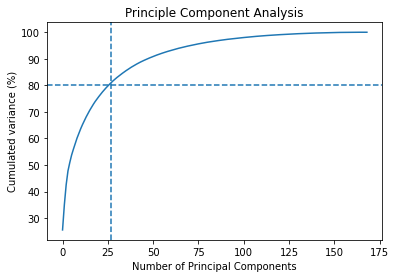

In [18]:
# Plot cross-validation results    
cum_explained_var = np.cumsum(np.round(pca4.explained_variance_ratio_, decimals=4)*100)

plt.plot(cum_explained_var)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulated variance (%)')
plt.axhline(y=80, linestyle='--')
plt.axvline(x = 27, linestyle='--')
plt.title('Principle Component Analysis')

In [19]:
np.cumsum(np.round(pca4.explained_variance_ratio_, decimals=4)*100)

array([25.59, 35.04, 42.57, 47.8 , 50.94, 53.74, 55.97, 58.05, 60.13,
       61.92, 63.62, 65.19, 66.62, 68.04, 69.34, 70.58, 71.75, 72.84,
       73.88, 74.83, 75.74, 76.61, 77.46, 78.25, 79.02, 79.74, 80.44,
       81.11, 81.74, 82.35, 82.91, 83.45, 83.97, 84.49, 84.99, 85.47,
       85.93, 86.39, 86.82, 87.23, 87.63, 88.01, 88.38, 88.73, 89.07,
       89.38, 89.69, 89.99, 90.28, 90.56, 90.84, 91.11, 91.36, 91.61,
       91.85, 92.08, 92.31, 92.53, 92.74, 92.94, 93.14, 93.34, 93.53,
       93.72, 93.9 , 94.07, 94.24, 94.4 , 94.56, 94.72, 94.87, 95.02,
       95.16, 95.3 , 95.44, 95.58, 95.71, 95.84, 95.96, 96.08, 96.2 ,
       96.31, 96.42, 96.52, 96.62, 96.72, 96.82, 96.92, 97.01, 97.1 ,
       97.19, 97.28, 97.36, 97.44, 97.52, 97.6 , 97.68, 97.75, 97.82,
       97.89, 97.96, 98.03, 98.1 , 98.17, 98.23, 98.29, 98.35, 98.41,
       98.47, 98.53, 98.58, 98.63, 98.68, 98.73, 98.78, 98.83, 98.88,
       98.92, 98.96, 99.  , 99.04, 99.08, 99.12, 99.16, 99.2 , 99.24,
       99.28, 99.31,

In [20]:
X_reduced_test = pca4.transform(scale(X_test))[:,:28]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:28], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

152923441.18624598

In [21]:
# R squared, coefficient of determination
# the percentatge of the dependent variable variation that a linear model explains

print(regr.score(X_reduced_test,y_test)) # acc

0.13357480127057886
